## NLP Class Assignment 6

Installing Tweet-preprocessor library to clean tweets

In [1]:
# !pip install tweet-preprocessor

In [1]:
import numpy as np
import pandas as pd
from gensim import corpora, models
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm

import re
import nltk
import preprocessor as p
import os

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 600)

#### Read news data

In [2]:
news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news/nlp_a_6_news.json'
news_df = pd.read_json(news_path, orient='records', lines=True)

print(f'Sample contains {news_df.shape[0]:,.0f} news articles')
news_df.head(2)

Sample contains 9,962 news articles


,url,date,language,title,text
0,http://oaklandnewsnow.com/breaking-bts-announces-las-vegas-us-concert-date-in-2022/,2022-02-24,en,"BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, World","BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSorry, you have Javascript Disabled! To see this page as it is meant to appear, please enable your Javascript!BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSkip to contentMenuSearch for:SearchOakland News Now – Oakland News, SF Bay Area, East Bay, California, WorldOakland News Now Oakland News YouTube Vlog News Aggregator Home • About • Oakland News • Authors • Lake Mer..."
1,http://www.newsdzezimbabwe.co.uk/2022/04/mai-tt-weds.html,2022-04-09,en,MAI TT WEDS newsdzeZimbabweNewsdzeZimbabwe,"MAI TT WEDS newsdzeZimbabweNewsdzeZimbabweskip to main | skip to sidebarHomeAboutContactAdvertiseNewsdzeZimbabweOur Zimbabwe Our NewsHomeNewsBusinessEntertainmentSaturday, 9 April 2022MAI TT WEDSSaturday, April 09, 2022 NewsdzeZimbabwe 0 Best moments... @Chakariboy @NyamayaroArron @restmutore @Lattynyangu pic.twitter.com/MsrhcFXUJj— H-Metro (@HMetro_) April 9, 2022 Posted in: Share to TwitterShare to FacebookOlder PostHome0comments: Post a CommentFollow NewsdzeZimbabweRecent CommentsPowered by DisqusFollow NewsdzeZimbabwePopular PostsTYCOON BEDS MOTHER AND DAUGHTERA woman ..."


#### Read Tweets data

In [3]:
tweets_path = 'https://storage.googleapis.com/msca-bdp-data-open/tweets/nlp_a_6_tweets.json'
tweets_df = pd.read_json(tweets_path, orient='records', lines=True)
print(f'Sample contains {tweets_df.shape[0]:,.0f} tweets')
tweets_df.head(2)

Sample contains 9,941 tweets


,id,lang,date,name,retweeted,text
0,1484553027222741001,en,2022-01-21,Dylan Green,RT,*Microsoft has entered the chat* https://t.co/Uz3pZrk6B3
1,1505486305102557184,en,2022-03-20,Rahim Rajwani,,"""I actually use an @Android phone. Some #Android manufacturers pre-install @Microsoft software in a way that makes it easy for me. They’re more flexible about how the software connects up with the OS. So that’s what I ended up getting used to.""\nhttps://t.co/C0VjfS9PUO"


Using the Preprocessor Library to clean tweets

In [4]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
tweet_tokenizer = nltk.tokenize.TweetTokenizer()
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yomaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def custom_standardization(input_data):
    processed_data = p.clean(input_data)
    lowercase_value = processed_data.lower()
    return lowercase_value

def tokenize_and_clean(text,stopwords_apply=True):
    text = custom_standardization(text)
    tokens = tweet_tokenizer.tokenize(text)
    tokens = [token for token in tokens if len(token) > 1]
    tokens = [token for token in tokens if not token.isnumeric()]
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token.lower() for token in tokens]
    if stopwords_apply:
        tokens = [token for token in tokens if token not in stopwords]
    return tokens

In [6]:
tweets_df['cleaned_text'] = tweets_df['text'].progress_apply(tokenize_and_clean,args=(False))

100%|██████████| 9941/9941 [00:01<00:00, 6452.75it/s]


In [7]:
dictionary_tweets = corpora.Dictionary(tweets_df['cleaned_text'])
corpus_tweets = [dictionary_tweets.doc2bow(doc) for doc in tqdm(tweets_df['cleaned_text'])]

print(f'Number of unique tokens: {len(dictionary_tweets)}')
print(f'Number of documents: {len(corpus_tweets)}')

100%|██████████| 9941/9941 [00:00<00:00, 173914.90it/s]

Number of unique tokens: 15470
Number of documents: 9941


In [8]:
def compute_coherence_values(corpus, dictionary, k,alpha,texts):
    
    lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=10,                  
                       passes=10,
                       alpha=alpha,
                       workers=os.cpu_count()
                   )
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [11]:
min_topics = 3
max_topics = 20
step_size = 1
topics_range = np.arange(min_topics, max_topics+1, step_size)
alpha_range = np.arange(0.1,1,0.1)
np.append(alpha_range,'assymetric')
np.append(alpha_range,'symetric')

# Validation sets
num_of_docs = len(corpus_tweets)

model_results = {
                 'Topics': [],
                 'Coherence': [],
                }

for k in tqdm(topics_range):
    for alpha in tqdm(alpha_range):
        cv = compute_coherence_values(corpus=corpus_tweets, dictionary=dictionary_tweets,k = k,alpha=alpha ,texts=tweets_df['cleaned_text'])
        model_results['Topics'].append(k)
        model_results['Coherence'].append(cv)

  0%|          | 0/18 [00:00<?, ?it/s]

In [11]:
lda_tuning = pd.DataFrame(model_results)
lda_tuning.sort_values(by=['Coherence'], ascending=False)

,Topics,Coherence
13,16,0.359860
11,14,0.338872
12,15,0.338782
17,20,0.334658
15,18,0.326312
16,19,0.325061
14,17,0.322283
5,8,0.308174
2,5,0.305620
4,7,0.294309


<Axes: xlabel='Topics'>

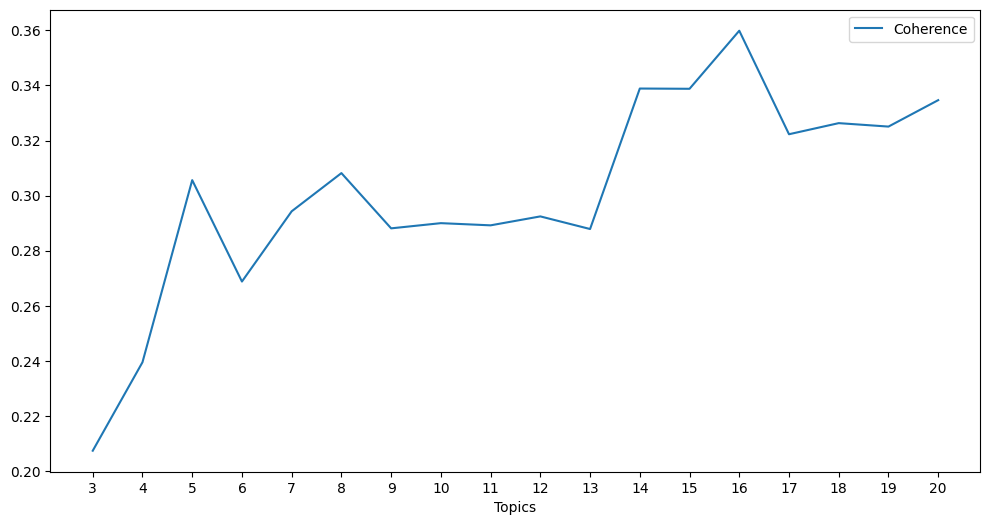

In [12]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line',figsize=(12,6),xticks=np.arange(3,21,1))

By the looks of it, there does not seem to be a distinct elbow, so we should take a look at the topics, to have a better understanding. 

In [13]:
search_results = {
                 'n_Topics': [],
                 'Topics': [],
                }
for i in tqdm(range(3,21,1)):
   ldamodel = LdaMulticore(corpus=tqdm(corpus_tweets),id2word=dictionary_tweets,num_topics=i,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
   search_results['n_Topics'].append(i)
   search_results['Topics'].append(ldamodel.print_topics())

100%|██████████| 18/18 [03:48<00:00, 12.71s/it]


In [14]:
topics_search = pd.DataFrame(search_results)
for i in range(len(topics_search)):
    topics = topics_search.iloc[i,1]
    print(topics_search.iloc[i,0])
    for j in topics:
        topic = j[1]
        topic = re.sub(r'[^A-Za-z]'," ",topic)
        topic = topic.replace("           "," ")
        print(topic)
    print("____________________________________________________________________________________________________________________")

3
       microsoft ever word activision xbox know excel new use like 
       microsoft windows new google apple like teams data azure cloud 
       microsoft premium xbox owns sony game grammarly netflix canva get 
____________________________________________________________________________________________________________________
4
       microsoft ever word new xbox like stop excel russia use 
       microsoft windows new apple google like teams azure billion cloud 
       microsoft premium owns grammarly netflix canva spotify quillbot number game 
       microsoft activision know xbox sony blizzard use new people one 
____________________________________________________________________________________________________________________
5
       microsoft ever word new stop use us like power xbox 
       microsoft apple windows new teams google azure like cloud tech 
       microsoft premium grammarly netflix canva spotify quillbot game viu scribd 
       microsoft activision know xbox s

Looking at the above topics, I feel that 6,7,8 topics makes sense, as all topics are distinct

In [15]:
lda_model = LdaMulticore(corpus=tqdm(corpus_tweets),id2word=dictionary_tweets,num_topics=6,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display = gensimvis.prepare(lda_model, corpus_tweets, dictionary_tweets, sort_topics=True)
pyLDAvis.display(lda_display)

100%|██████████| 9941/9941 [00:09<00:00, 1072.97it/s]


In [16]:
lda_model_tweet_7 = LdaMulticore(corpus=tqdm(corpus_tweets),id2word=dictionary_tweets,num_topics=7,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display = gensimvis.prepare(lda_model_tweet_7, corpus_tweets, dictionary_tweets, sort_topics=True)
pyLDAvis.display(lda_display)

100%|██████████| 9941/9941 [00:09<00:00, 1068.67it/s]


In [17]:
lda_model = LdaMulticore(corpus=tqdm(corpus_tweets),id2word=dictionary_tweets,num_topics=8,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display = gensimvis.prepare(lda_model, corpus_tweets, dictionary_tweets, sort_topics=True)
pyLDAvis.display(lda_display)

100%|██████████| 9941/9941 [00:09<00:00, 1073.89it/s]


Looking at the above visualizations, it looks like there is a big bunch of topics, that are common. So we should probably go less than 6, and look at 3,4,5

In [18]:
lda_model = LdaMulticore(corpus=tqdm(corpus_tweets),id2word=dictionary_tweets,num_topics=5,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display = gensimvis.prepare(lda_model, corpus_tweets, dictionary_tweets, sort_topics=True)
pyLDAvis.display(lda_display)

100%|██████████| 9941/9941 [00:09<00:00, 1074.31it/s]


In [19]:
lda_model = LdaMulticore(corpus=tqdm(corpus_tweets),id2word=dictionary_tweets,num_topics=4,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display = gensimvis.prepare(lda_model, corpus_tweets, dictionary_tweets, sort_topics=True)
pyLDAvis.display(lda_display)

100%|██████████| 9941/9941 [00:09<00:00, 1069.25it/s]


In [20]:
lda_model = LdaMulticore(corpus=tqdm(corpus_tweets),id2word=dictionary_tweets,num_topics=3,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display = gensimvis.prepare(lda_model, corpus_tweets, dictionary_tweets, sort_topics=True)
pyLDAvis.display(lda_display)

100%|██████████| 9941/9941 [00:09<00:00, 1072.32it/s]


Looks like 4,5,6,7 topics is able to show all topics, without significant overlap, but 4 Topics, 5 Topics and 7 Topics seem to show the most distinct topics. I would personally choose 7 Topics. 

In [64]:
lda_model_tweet_7.save("Tweets_7_topics")

## For News Data

In [22]:
news_df['cleaned_text'] = news_df['text'].progress_apply(tokenize_and_clean)

100%|██████████| 9962/9962 [01:47<00:00, 92.34it/s] 


In [23]:
dictionary_news = corpora.Dictionary(news_df['cleaned_text'])
corpus_news = [dictionary_news.doc2bow(doc) for doc in tqdm(news_df['cleaned_text'])]

print(f'Number of unique tokens: {len(dictionary_news)}')
print(f'Number of documents: {len(corpus_news)}')

100%|██████████| 9962/9962 [00:03<00:00, 2525.34it/s]

Number of unique tokens: 317442
Number of documents: 9962


In [24]:
min_topics = 3
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Validation sets
num_of_docs = len(corpus_news)

model_results_news = {
                 'Topics': [],
                 'Coherence': [],
                }

for k in tqdm(topics_range):
    cv = compute_coherence_values(corpus=corpus_news, dictionary=dictionary_news, k = k,texts=news_df['cleaned_text'])
    model_results_news['Topics'].append(k)
    model_results_news['Coherence'].append(cv)

100%|██████████| 18/18 [22:24<00:00, 74.71s/it]


In [25]:
lda_tuning = pd.DataFrame(model_results_news)
lda_tuning.sort_values(by=['Coherence'], ascending=False)

,Topics,Coherence
4,7,0.420527
5,8,0.412551
8,11,0.397731
6,9,0.395797
9,12,0.392233
7,10,0.381591
10,13,0.379347
13,16,0.379069
12,15,0.377465
11,14,0.372087


<Axes: xlabel='Topics'>

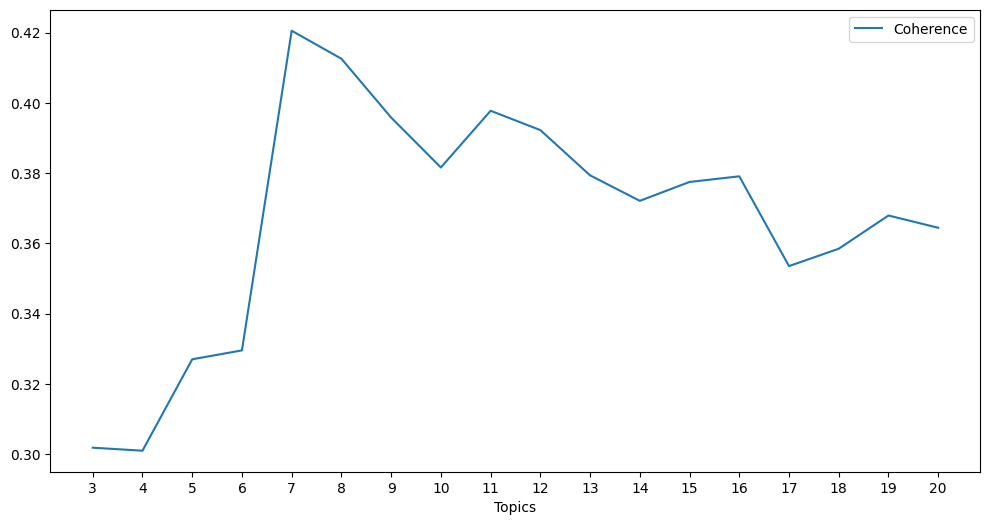

In [26]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line',figsize=(12,6),xticks=np.arange(3,21,1))

Looking at the above graph, there is some semblance for an elbow from 6 to 12 topics, so lets view the topics in that range

In [27]:
search_results_news = {
                 'n_Topics': [],
                 'Topics': [],
                }
for i in tqdm(range(3,13,1)):
   ldamodel_news = LdaMulticore(corpus=corpus_news,id2word=dictionary_news,num_topics=i,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
   search_results_news['n_Topics'].append(i)
   search_results_news['Topics'].append(ldamodel_news.print_topics())

100%|██████████| 10/10 [08:55<00:00, 53.59s/it]


In [28]:
topics_search_news = pd.DataFrame(search_results_news)
for i in range(len(topics_search_news)):
    topics = topics_search_news.iloc[i,1]
    print(topics_search_news.iloc[i,0])
    for j in topics:
        topic = j[1]
        topic = re.sub(r'[^A-Za-z]'," ",topic)
        topic = topic.replace("           "," ")
        print(topic)
    print("____________________________________________________________________________________________________________________")

3
       video music official resize https quality strip news new song 
       new pt best news cookie said pm may first style 
       new market news us ago may business data company also 
____________________________________________________________________________________________________________________
4
       video music official resize https quality strip news new song 
       new pt cookie best news pm said style first may 
       new ago news us may hours also opens days said 
       market shares stock inc new news us company stocks global 
____________________________________________________________________________________________________________________
5
       video music official resize https quality strip news new song 
       new pt cookie pm said style news used set people 
       new ago news best opens hours tab may days us 
       market new us best says first video news top global 
       news new stock inc market shares company us data nasdaq 
____________________

Lets take a look at the 5,6,7,8,9 topics range

In [29]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news),id2word=dictionary_news,num_topics=5,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news, dictionary_news, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:12<00:00, 790.52it/s]


In [30]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news),id2word=dictionary_news,num_topics=6,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news, dictionary_news, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:12<00:00, 785.63it/s]


In [31]:
lda_model_news_7 = LdaMulticore(corpus=tqdm(corpus_news),id2word=dictionary_news,num_topics=7,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news_7, corpus_news, dictionary_news, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:12<00:00, 788.31it/s]


In [32]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news),id2word=dictionary_news,num_topics=8,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news, dictionary_news, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:12<00:00, 788.79it/s]


In [33]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news),id2word=dictionary_news,num_topics=9,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news, dictionary_news, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:12<00:00, 768.43it/s]


As we can see 7 topics seems to be the best distribution, as the indivdual topics makes sense, while being distinct enough from each other, but 6 topics also seems to be having distinct topics.

In [34]:
lda_model_news_7.save("News_text_7_topics")

## News Titles

In [35]:
news_df['cleaned_title'] = news_df['title'].progress_apply(tokenize_and_clean,args=(False))

100%|██████████| 9962/9962 [00:00<00:00, 11013.67it/s]


In [36]:
dictionary_news_title = corpora.Dictionary(news_df['cleaned_title'])
corpus_news_title = [dictionary_news_title.doc2bow(doc) for doc in tqdm(news_df['cleaned_title'])]

print(f'Number of unique tokens: {len(dictionary_news_title)}')
print(f'Number of documents: {len(corpus_news_title)}')

100%|██████████| 9962/9962 [00:00<00:00, 249045.78it/s]

Number of unique tokens: 16570
Number of documents: 9962


In [37]:
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Validation sets
num_of_docs = len(corpus_news_title)

model_results_news = {
                 'Topics': [],
                 'Coherence': [],
                }

for k in tqdm(topics_range):
    cv = compute_coherence_values(corpus=corpus_news_title, dictionary=dictionary_news_title, k = k,texts = news_df['cleaned_title'])
    model_results_news['Topics'].append(k)
    model_results_news['Coherence'].append(cv)


100%|██████████| 19/19 [06:19<00:00, 19.99s/it]


In [38]:
lda_tuning = pd.DataFrame(model_results_news)
lda_tuning.sort_values(by=['Coherence'], ascending=False)

,Topics,Coherence
2,4,0.404591
1,3,0.402280
3,5,0.393142
0,2,0.385651
7,9,0.382025
12,14,0.380603
15,17,0.378666
11,13,0.378613
5,7,0.376473
16,18,0.372935


<Axes: xlabel='Topics'>

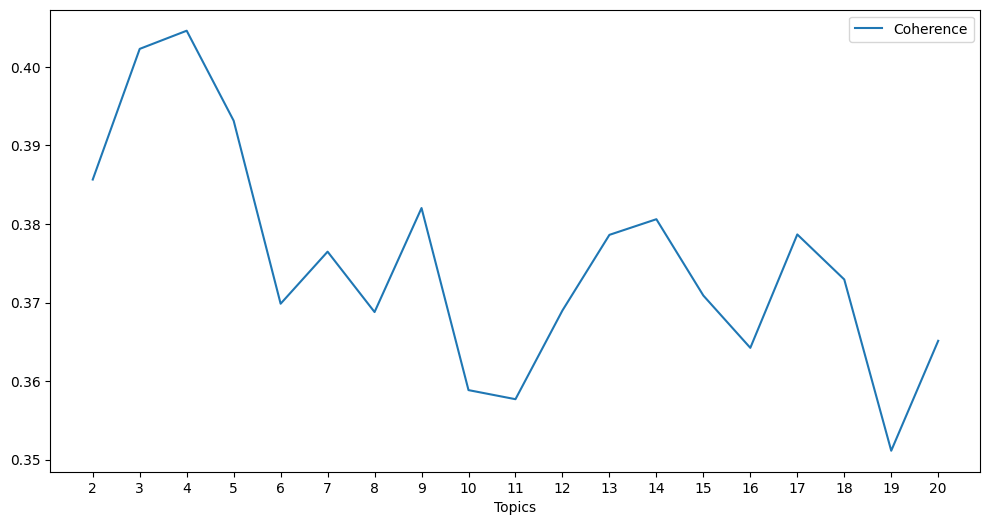

In [39]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line',figsize=(12,6),xticks=np.arange(2,21,1))

Looking at the above graph, It is clear that 4 topics seems, perfect as it has the highest coherence, but lets take a look at the topics from 2-5

In [40]:
search_results_news = {
                 'n_Topics': [],
                 'Topics': [],
                }
for i in tqdm(range(2,6,1)):
   ldamodel_news = LdaMulticore(corpus=corpus_news_title,id2word=dictionary_news_title,num_topics=i,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
   search_results_news['n_Topics'].append(i)
   search_results_news['Topics'].append(ldamodel_news.print_topics())

100%|██████████| 4/4 [00:51<00:00, 12.86s/it]


In [41]:
topics_search_news = pd.DataFrame(search_results_news)

In [42]:
for i in range(len(topics_search_news)):
    topics = topics_search_news.iloc[i,1]
    print(topics_search_news.iloc[i,0])
    for j in topics:
        topic = j[1]
        topic = re.sub(r'[^A-Za-z]'," ",topic)
        topic = topic.replace("           "," ")
        print(topic)
    print("____________________________________________________________________________________________________________________")

2
       news equities newsbreak falls microsoft times best january seattle new 
       news times seattle market new daily inc bloomberg bnn global 
____________________________________________________________________________________________________________________
3
       news equities falls newsbreak best january microsoft business new close 
       news times seattle new market inc daily global microsoft techradar 
       times seattle news daily new market bnn bloomberg report microsoft 
____________________________________________________________________________________________________________________
4
       news equities falls newsbreak best microsoft january us stocks philips 
       news market seattle times new global techradar microsoft digital newsbreak 
       times seattle news bnn bloomberg newsbreak market new daily bay 
       news times inc seattle daily new nasdaq shares etf nyse 
____________________________________________________________________________________

Lets take a look at the 2-6 topics range

In [43]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news_title),id2word=dictionary_news_title,num_topics=2,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news_title, dictionary_news_title, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:09<00:00, 1075.12it/s]


In [44]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news_title),id2word=dictionary_news_title,num_topics=3,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news_title, dictionary_news_title, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:09<00:00, 1072.00it/s]


In [45]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news_title),id2word=dictionary_news_title,num_topics=4,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news_title, dictionary_news_title, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:09<00:00, 1080.36it/s]


In [46]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news_title),id2word=dictionary_news_title,num_topics=5,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news_title, dictionary_news_title, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:09<00:00, 1075.61it/s]


In [47]:
lda_model_news_6_title = LdaMulticore(corpus=tqdm(corpus_news_title),id2word=dictionary_news_title,num_topics=6,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news_6_title, corpus_news_title, dictionary_news_title, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:09<00:00, 1027.96it/s]


From the above it is clear that 6 topics emerges as the clear winner as the topics are distinct enough, but with a high enough coherence score.

In [63]:
lda_model_news_6_title.save("News_title_6_topics")

## NEWS with Title + Text

In [49]:
news_df['title_text'] = news_df['title'] + news_df['text']
news_df['cleaned_title_text'] = news_df['title_text'].progress_apply(tokenize_and_clean,args=(False))

100%|██████████| 9962/9962 [01:48<00:00, 91.85it/s] 


In [50]:
dictionary_news_title_text = corpora.Dictionary(news_df['cleaned_title_text'])
corpus_news_title_text = [dictionary_news_title_text.doc2bow(doc) for doc in tqdm(news_df['cleaned_title_text'])]

print(f'Number of unique tokens: {len(dictionary_news_title_text)}')
print(f'Number of documents: {len(corpus_news_title_text)}')

100%|██████████| 9962/9962 [00:04<00:00, 2403.81it/s]

Number of unique tokens: 321659
Number of documents: 9962


In [51]:
min_topics = 3
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Validation sets
num_of_docs = len(corpus_news_title_text)

model_results_news_title_text = {
                 'Topics': [],
                 'Coherence': [],
                }

for k in tqdm(topics_range):
    cv = compute_coherence_values(corpus=corpus_news_title_text, dictionary=dictionary_news_title_text, k = k,texts=news_df['cleaned_title_text'])
    model_results_news_title_text['Topics'].append(k)
    model_results_news_title_text['Coherence'].append(cv)
                    
lda_tuning = pd.DataFrame(model_results_news_title_text)
lda_tuning.to_csv('lda_tuning_results.csv', index=False)

100%|██████████| 18/18 [24:06<00:00, 80.38s/it] 


In [52]:
lda_tuning = pd.DataFrame(model_results_news_title_text)
lda_tuning.sort_values(by=['Coherence'], ascending=False)

,Topics,Coherence
13,16,0.453551
14,17,0.447423
7,10,0.440660
12,15,0.437033
8,11,0.430741
11,14,0.423987
16,19,0.422616
9,12,0.417437
10,13,0.415831
17,20,0.415167


<Axes: xlabel='Topics'>

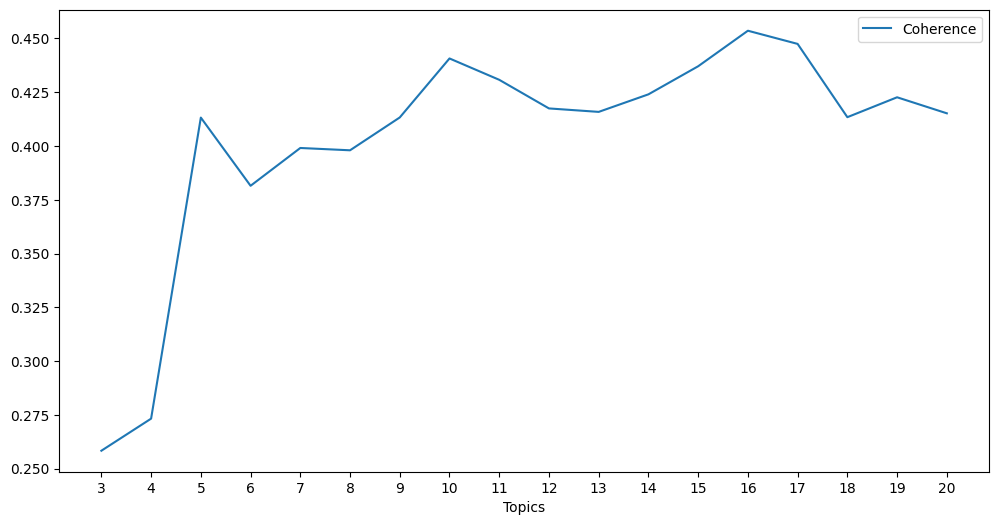

In [53]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line',figsize=(12,6),xticks=np.arange(3,21,1))

Looking at the above graph, there is some semblance for an elbow from 6 to 12 topics, so lets view the topics in that range

In [54]:
search_results_news_title_text = {
                 'n_Topics': [],
                 'Topics': [],
                }
for i in tqdm(range(5,13,1)):
   ldamodel_news_title_text = LdaMulticore(corpus=corpus_news_title_text,id2word=dictionary_news_title_text,num_topics=i,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
   search_results_news_title_text['n_Topics'].append(i)
   search_results_news_title_text['Topics'].append(ldamodel_news_title_text.print_topics())

100%|██████████| 8/8 [08:40<00:00, 65.01s/it]


In [55]:
topics_search_news_title_text = pd.DataFrame(search_results_news_title_text)
for i in range(len(topics_search_news_title_text)):
    topics = topics_search_news_title_text.iloc[i,1]
    print(topics_search_news_title_text.iloc[i,0])
    for j in topics:
        topic = j[1]
        topic = re.sub(r'[^A-Za-z]'," ",topic)
        topic = topic.replace("           "," ")
        print(topic)
    print("____________________________________________________________________________________________________________________")

5
       video music official news new song oakland black shares nfl 
       new pt best pm style news opens games game video 
       new news us first day says market video ago best 
       market news new data us said ago cookie business may 
       resize https quality strip file image width height jpeg filesize 
____________________________________________________________________________________________________________________
6
       video music official news new song oakland black shares nfl 
       new pt best pm style games game news video may 
       new us news market first says day video star best 
       market news new data us said ago cookie business may 
       resize https quality strip file image width height jpeg filesize 
       new opens tab link news music people email video best 
____________________________________________________________________________________________________________________
7
       video music official news new song oakland black shares nfl 

Lets take a look at the 5,6,7,8,9 topics range

In [56]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news_title_text),id2word=dictionary_news_title_text,num_topics=5,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news_title_text, dictionary_news_title_text, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:16<00:00, 600.68it/s]


In [57]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news_title_text),id2word=dictionary_news_title_text,num_topics=6,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news_title_text, dictionary_news_title_text, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:16<00:00, 592.39it/s]


In [58]:
lda_model_news_7_title_text = LdaMulticore(corpus=tqdm(corpus_news_title_text),id2word=dictionary_news_title_text,num_topics=7,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news_7_title_text, corpus_news_title_text, dictionary_news_title_text, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:14<00:00, 674.38it/s]


In [59]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news_title_text),id2word=dictionary_news_title_text,num_topics=8,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news_title_text, dictionary_news_title_text, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:15<00:00, 627.60it/s]


In [60]:
lda_model_news = LdaMulticore(corpus=tqdm(corpus_news_title_text),id2word=dictionary_news_title_text,num_topics=9,random_state=10,passes=10,alpha='symmetric',workers=os.cpu_count())
lda_display_news = gensimvis.prepare(lda_model_news, corpus_news_title_text, dictionary_news_title_text, sort_topics=True)
pyLDAvis.display(lda_display_news)

100%|██████████| 9962/9962 [00:14<00:00, 690.66it/s]


It is clear from the above results, that 7 topics is the best as it has topics that are very distinct from each other, and 6 topics is a close second.

In [62]:
lda_model_news_7_title_text.save("News_text_title_7_topics")